## Constants

In [1]:
pathToTrainImages = "D:/Perfect Shape Images/Train/"
pathToTestImages = "D:/Perfect Shape Images/Test/"

In [2]:
BATCH_SIZE = 4

## Imports

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import os

## Create Dataloader

### Create Dataloader Class

In [4]:
class ShapeDataset(Dataset):
    """Shape dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample. -> Not used
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                str(idx)+ '.jpg')
        image = cv2.imread(img_name)

        if self.transform:
            image = self.transform(image)

        #perfect square should yield strongest activation which will be 1
        return image, 1

### Set Transforms

In [5]:
transform = transforms.ToTensor()

### Create datasets and dataloaders

In [6]:
trainset = ShapeDataset(pathToTrainImages, transform)
testset = ShapeDataset(pathToTrainImages, transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## View Sample Images + Test Loaders

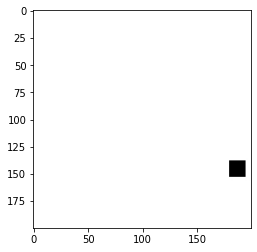

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, label = dataiter.next()

npimg = np.transpose(images[0], (1, 2, 0))

plt.imshow(npimg)

## Create CNN

### Define Network

In [68]:
class SquareNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.conv2 = nn.Conv2d(20, 40, 3)
        self.conv3 = nn.Conv2d(40, 60, 3)
        self.fc1 = nn.Linear(13500, 5000)
        self.fc2 = nn.Linear(5000, 1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(3)    
        self.sigmoid = nn.Sigmoid()
        self.identity = nn.Conv2d(3, 3, 1)
        
        
    

    def forward(self, x):
        #Next: Add identity mapping that has gradients, freeze it
        #Unfreeze the identity layer during testing
        x = self.identity(x)
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool1(F.relu(self.conv2(x)))
        x = self.maxpool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [76]:
net = SquareNet()

In [77]:
net.identity.weight = torch.nn.Parameter(torch.Tensor([[[[ 1]],

         [[ 0]],

         [[ 0]]],


        [[[0]],

         [[1]],

         [[0]]],


        [[[ 0]],

         [[ 0]],

         [[1]]]]))

In [78]:
net.identity.bias = torch.nn.Parameter(torch.Tensor([0, 0, 0]))

In [79]:
net.identity.weight.requires_grad = False
net.identity.bias.requires_grad = False

In [80]:
net.to("cuda")

SquareNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13500, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1, bias=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (identity): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

## Define Loss Function and Optimizer

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [82]:
lossList = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        labels = labels[...,None]

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        lossList.append(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.6f}')
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.044293
[1,    10] loss: 0.000821
[1,    15] loss: 0.000145
[1,    20] loss: 0.000037
[1,    25] loss: 0.000033
[1,    30] loss: 0.000014
[1,    35] loss: 0.000008
[1,    40] loss: 0.000005
[1,    45] loss: 0.000005
[1,    50] loss: 0.000006
[2,     5] loss: 0.000003
[2,    10] loss: 0.000002
[2,    15] loss: 0.000003
[2,    20] loss: 0.000001
[2,    25] loss: 0.000002
[2,    30] loss: 0.000001
[2,    35] loss: 0.000003
[2,    40] loss: 0.000001
[2,    45] loss: 0.000001
[2,    50] loss: 0.000001
Finished Training


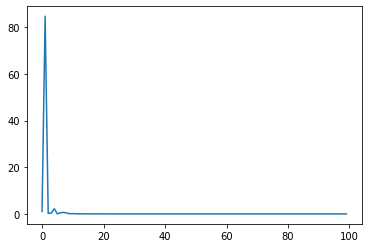

In [83]:
plt.plot(lossList)

In [84]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to("cuda"), labels.to("cuda")

outputs = net(images)

In [85]:
outputs

tensor([[1.0019],
        [0.9967],
        [0.9942],
        [0.9900]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Freeze rest of network and unfreeze identity layer

In [93]:
for param in net.parameters():
    param.requires_grad = False

net.identity.weight.requires_grad = True
net.identity.bias.require_grad = True

net.to("cuda")

SquareNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13500, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1, bias=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (identity): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [94]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [95]:
rec = torch.Tensor(cv2.imread(pathToTestImages + "rectangle.jpg"))
rec = rec[...,None]
rec = np.transpose(rec, (3, 2, 0, 1))
rec = rec.to("cuda")

In [96]:
labels = torch.Tensor([1])
labels = labels.to("cuda")
labels = labels[...,None]
labels

tensor([[1.]], device='cuda:0')

In [97]:
optimizer.zero_grad()

In [98]:
outputs = net(rec)
outputs

tensor([[186.8507]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [99]:
loss = criterion(outputs, labels.float())

In [ ]:
loss.backward()

# Edit original image

In [101]:
net.identity.weight.grad

tensor([[[[35922.9023]],

         [[35922.9023]],

         [[35922.9023]]],


        [[[10235.4561]],

         [[10235.4551]],

         [[10235.4551]]],


        [[[23190.0703]],

         [[23190.0703]],

         [[23190.0703]]]], device='cuda:0')

## Testing Code

In [86]:
rec = torch.Tensor(cv2.imread(pathToTestImages + "rectangle.jpg"))
rec = rec[...,None]
rec = np.transpose(rec, (3, 2, 0, 1))
rec = rec.to("cuda")
output = net(rec)

In [87]:
output

tensor([[186.8507]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [88]:
m = net.identity
m.to("cuda")

Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))

In [89]:
test = m(images)

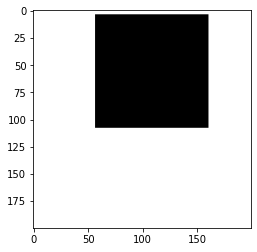

In [90]:
newImg = test[0].cpu().detach().numpy()
bgr = np.transpose(newImg, (1, 2, 0))


plt.imshow(bgr)


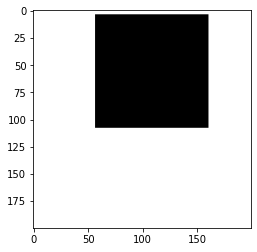

In [91]:
newImg = images[0].cpu().detach().numpy()
bgr = np.transpose(newImg, (1, 2, 0))


plt.imshow(bgr)